In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import shutil
from tensorflow import keras

import tensorflow as tf
from keras.utils import plot_model

from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tqdm.pandas()
import plotly.graph_objects as go

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tntrnh","key":"80f3e16d93f84fe445f6e1f46bb7e24e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c plant-pathology-2020-fgvc7

100% 778M/779M [00:41<00:00, 23.5MB/s]
100% 779M/779M [00:41<00:00, 19.7MB/s]


In [ ]:
! unzip plant-pathology-2020-fgvc7.zip -d data
! rm plant-pathology-2020-fgvc7.zip

Archive:  plant-pathology-2020-fgvc7.zip
  inflating: data/images/Test_0.jpg  
  inflating: data/images/Test_1.jpg  
  inflating: data/images/Test_10.jpg  
  inflating: data/images/Test_100.jpg  
  inflating: data/images/Test_1000.jpg  
  inflating: data/images/Test_1001.jpg  
  inflating: data/images/Test_1002.jpg  
  inflating: data/images/Test_1003.jpg  
  inflating: data/images/Test_1004.jpg  
  inflating: data/images/Test_1005.jpg  
  inflating: data/images/Test_1006.jpg  
  inflating: data/images/Test_1007.jpg  
  inflating: data/images/Test_1008.jpg  
  inflating: data/images/Test_1009.jpg  
  inflating: data/images/Test_101.jpg  
  inflating: data/images/Test_1010.jpg  
  inflating: data/images/Test_1011.jpg  
  inflating: data/images/Test_1012.jpg  
  inflating: data/images/Test_1013.jpg  
  inflating: data/images/Test_1014.jpg  
  inflating: data/images/Test_1015.jpg  
  inflating: data/images/Test_1016.jpg  
  inflating: data/images/Test_1017.jpg  
  inflating: data/images/T

In [ ]:
IMAGE_PATH = "/content/data/images"
TRAIN_PATH = "/content/data/train"
VALID_PATH = "/content/data/valid"
TEST_PATH = "/content/data/test"
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
IMAGE_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
MAX_ACC = 0.95
BASE_LEARNING_RATE = 0.0001

In [ ]:
train = pd.read_csv('/content/data/train.csv')
diseases = list(train)[1:]
test = pd.read_csv('/content/data/test.csv')
train['image_id']=train['image_id']+'.jpg'
test['image_id']=test['image_id']+'.jpg'
train.head()


,image_id,healthy,multiple_diseases,rust,scab
0,Train_0.jpg,0,0,0,1
1,Train_1.jpg,0,1,0,0
2,Train_2.jpg,1,0,0,0
3,Train_3.jpg,0,0,1,0
4,Train_4.jpg,1,0,0,0


In [ ]:
if os.path.isdir(TRAIN_PATH) is False:
    # Create train, validation, test folders
    os.mkdir(TRAIN_PATH)    
    os.mkdir(VALID_PATH)
    os.mkdir(TEST_PATH)
    # Copy training images to test folder
    for img_id in test['image_id']:
      shutil.copy(f'/content/data/images/{img_id}', TEST_PATH)


In [ ]:
    for disease in diseases:
        # Create disease(healthy, multi-diseases, rust, scab) folder
        os.mkdir(f'/content/data/train/{disease}')
        os.mkdir(f'/content/data/valid/{disease}')
        
        # Get all image have disease = 1
        images_id = train[train[disease] == 1].image_id.values

        # Split data
        train_id, valid_id = train_test_split(images_id, test_size = 0.1)

        # Copy training images to train folder
        for img_id in train_id:
            shutil.copy(f'/content/data/images/{img_id}', f'/content/data/train/{disease}')
        for img_id in train_id:
            shutil.copy(f'/content/data/images/{img_id}', f'/content/data/train')
        
        # Copy validation images to validation folder
        for img_id in valid_id:
            shutil.copy(f'/content/data/images/{img_id}', f'/content/data/valid/{disease}')
        for img_id in valid_id:
            shutil.copy(f'/content/data/images/{img_id}', f'/content/data/valid')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# đọc dữ liệu và trực quan một vài mẫu
train_datagen = ImageDataGenerator(rescale=1/255,
                              rotation_range=40,
                              width_shift_range=.2,
                              height_shift_range=.2,
                              shear_range=.2,
                              zoom_range=.2,
                              horizontal_flip=True,
                              fill_mode='nearest')

train_data = train_datagen.flow_from_directory('/content/data/train',
                                               target_size=IMAGE_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1/255,
                                        rotation_range=40,
                                        width_shift_range=.2,
                                        height_shift_range=.2,
                                        shear_range=.2,
                                        zoom_range=.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')
valid_data = valid_datagen.flow_from_directory('/content/data/valid',
                                             target_size=IMAGE_SIZE,
                                             batch_size=BATCH_SIZE, 
                                             class_mode='categorical')


test_datagen = ImageDataGenerator(rescale=1/255)
test_data=test_datagen.flow_from_dataframe(test,
                                          directory='/content/data/test',
                                          target_size=IMAGE_SIZE,
                                          x_col="image_id",
                                          y_col=None,
                                          class_mode=None,
                                          shuffle=False,
                                          batch_size=BATCH_SIZE)



Found 1636 images belonging to 4 classes.
Found 185 images belonging to 4 classes.
Found 1821 validated image filenames.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=IMAGE_SHAPE
)
pretrained_model.trainable = True

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 average_pooling2d_2 (Averag  (None, 3, 3, 512)        0         
 ePooling2D)                                                     
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 4)                

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
              loss=['categorical_crossentropy'],
              metrics=['accuracy'])


In [ ]:
checkpoint_path = "/content/drive/MyDrive/GOOGLE COLAB/Plant_Diseases/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
        
model = model.fit(
  train_data,
  validation_data = valid_data,
  epochs=25,
  steps_per_epoch=len(train_data),
  validation_steps= len(valid_data),
  callbacks =[cp_callback]
)


Epoch 1/25
52/52 [==============================] - ETA: 0s - loss: 1.2709 - accuracy: 0.3447
Epoch 1: saving model to /content/drive/MyDrive/GOOGLE COLAB/Plant_Diseases/cp.ckpt
52/52 [==============================] - 98s 2s/step - loss: 1.2709 - accuracy: 0.3447 - val_loss: 1.2326 - val_accuracy: 0.4000
Epoch 2/25
52/52 [==============================] - ETA: 0s - loss: 1.2064 - accuracy: 0.4108
Epoch 2: saving model to /content/drive/MyDrive/GOOGLE COLAB/Plant_Diseases/cp.ckpt
52/52 [==============================] - 80s 2s/step - loss: 1.2064 - accuracy: 0.4108 - val_loss: 1.1082 - val_accuracy: 0.5189
Epoch 3/25
52/52 [==============================] - ETA: 0s - loss: 1.0786 - accuracy: 0.5159
Epoch 3: saving model to /content/drive/MyDrive/GOOGLE COLAB/Plant_Diseases/cp.ckpt
52/52 [==============================] - 80s 2s/step - loss: 1.0786 - accuracy: 0.5159 - val_loss: 0.9918 - val_accuracy: 0.5784
Epoch 4/25
52/52 [==============================] - ETA: 0s - loss: 0.7433 - ac

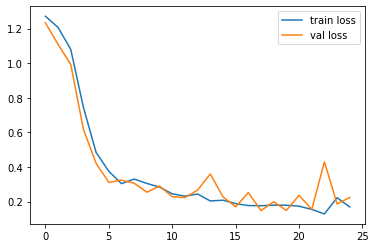

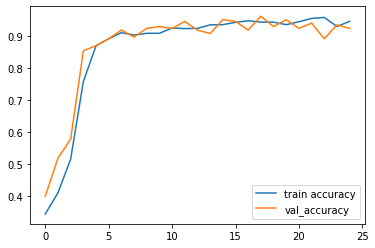

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model.history['loss'], label='train loss')
plt.plot(model.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(model.history['accuracy'], label='train accuracy')
plt.plot(model.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()